 # Sensory Activity Challenge – Pre-Processing Walkthrough & Data Understanding

 **Autoren:** Arian Iseni, Sahan Hatemo  **Datum:** 13. Juni 2025


Dieses Notebook beschreibt den vollständigen Preprocessing-Workflow für die sensorbasierten Aktivitätsdaten.
Ziel ist es, sowohl klassische ML-Features (NDL) als auch Deep Learning Sequenzen (DL) vorzubereiten.



 ```bash

 pip install -r requirements.txt

 ```

 ---

 ## Inhaltsverzeichnis



 **Domänenverständnis**

 1. Feature-Beschreibung

    1.1 Relevante Literatur & Parameter-Entscheidungen

 2. Datenüberblick & EDA



 **Preprocessing Pipeline**

 1. Rohdaten laden und vorbereiten

 2. Zeitbasiertes Trimmen & Resampling

 3. Segmentierung in überlappende Zeitfenster

 4. Filterung & Glättung jedes Segments

 5. Feature-Extraktion (für NDL)

 6. Label-Zuordnung

 7. Sequenzbildung (für DL)



 **Reflexion**

 8. Kreative Alternativen

 9. Lessons Learned

 10. Links zu Modell-Notebooks

 ---

 ### 1. Feature-Beschreibung für Sensor-based Activity Recognition

Im Rahmen dieser Herausforderung zur Aktivitätserkennung auf Basis von Sensordaten haben wir eine Vielzahl aggregierter Merkmale aus unterschiedlichen Sensormodulen extrahiert, um sowohl klassische maschinelle Lernverfahren (Random Forest, SVM, KNN) als auch tiefe Lernmodelle (z. B. MLP) zu trainieren. Die Daten wurden sequenziell in Zeitfenster segmentiert, wobei pro Segment statistische Kennwerte berechnet wurden. Die Zielvariable ist `label`, die das Aktivitätsmuster (z. B. Gehen, Laufen, Ruhen) angibt. Die Variable `file` dient zur Identifikation der Ursprungsdatei bzw. Datenquelle.

Die verwendeten Variablen lassen sich wie folgt kategorisieren:

1. **Zeitliche Merkmale**  
   - `seconds_elapsed_mean`, `seconds_elapsed_std`, `seconds_elapsed_min`, `seconds_elapsed_max`  
   → Beschreiben die Dauer der Aktivitätssegmente.

2. **Bewegungssensoren**  
   a. *Beschleunigung (Accelerometer)*  
   - `accelerometer_[x/y/z]_[mean/std/min/max]`  
   → Erfassen die lineare Beschleunigung in drei Raumachsen.

   b. *Gyroskop*  
   - `gyroscope_[x/y/z]_[mean/std/min/max]`  
   → Messen die Winkelgeschwindigkeit in drei Raumachsen.

   c. *Magnetometer*  
   - `magnetometer_[x/y/z]_[mean/std/min/max]`  
   → Geben die Magnetfeldstärke an, hilfreich für Richtungserkennung.

   d. *Gravitationskomponente*  
   - `gravity_[x/y/z]_[mean/std/min/max]`  
   → Isolieren die Gravitation vom Beschleunigungssignal.

3. **Orientierungsmerkmale**  
   a. *Euler-Winkel*  
   - `orientation_[pitch/roll/yaw]_[mean/std/min/max]`  
   → Geben die Ausrichtung des Geräts im Raum an (Neigung, Kippung, Drehung).

   b. *Quaternionen*  
   - `orientation_q[w/x/y/z]_[mean/std/min/max]`  
   → Alternative Repräsentation der Raumorientierung, insbesondere geeignet zur Vermeidung von Gimbal Lock und zur reibungslosen Integration in tiefergehende Lernmodelle.

Alle Merkmale sind numerisch und standardisiert auf Zeitfensterbasis. Durch die Verwendung von statistischen Kennzahlen (Mittelwert, Standardabweichung, Minimum, Maximum) pro Achse und Sensortyp wird sichergestellt, dass sowohl zentrale Tendenzen als auch Variabilität in den Bewegungsdaten abgebildet werden. Diese umfangreiche Merkmalsmenge bildet die Grundlage für eine differenzierte Modellierung und Klassifikation menschlicher Aktivitäten auf Basis multimodaler Sensordaten.



## 1.1 Relevante Literatur & Parameter-Entscheidungen (K1 / K6)

Für die Wahl der zentralen Hyperparameter (Sampling-Rate, Fenstergrösse, Überlappung) im Bereich der Aktivitätsklassifikation mittels Activity Tracking mit Wearables stützen wir uns auf folgende aktuelle und relevante Literatur. Die Ergebnisse dieser Arbeiten werden hier explizit auf unsere Anwendung – also die Klassifikation von Aktivitäten – übertragen und interpretiert.

---

### **1. Sampling-Rate**

**A study of the influence of the sensor sampling frequency on the effectiveness of wearable fall detection systems**  
*José Antonio Santoyo-Ramón, Eduardo Casilari, José Manuel Cano-García (Sensors, 2022)*  

[DOI: 10.1016/j.measurement.2022.110945](https://doi.org/10.1016/j.measurement.2022.110945)

**Interpretation für Activity Tracking:**  
Das Paper untersucht, wie sich verschiedene Sampling-Raten (3–200 Hz) auf die Genauigkeit von Machine-Learning-Modellen zur Aktivitätserkennung auswirken. Es zeigt, dass bereits ab ca. 20–22 Hz eine sehr hohe Genauigkeit (>97 %) erreicht wird und höhere Raten nur noch minimale Verbesserungen bringen. Für die Aktivitätsklassifikation mit Wearables bedeutet das: Eine Sampling-Rate von 50 Hz ist mehr als ausreichend und bietet einen guten Kompromiss zwischen Genauigkeit und Energieverbrauch.

> „Results seem to evince that with a rate of 22 Hz most machine learning classifiers can achieve a high accuracy (higher than 97%) to support fall detection systems.“ (Santoyo-Ramón et al., 2022)

...



**Human activity recognition system using wearable accelerometers for classification of leg movements: a first, detailed approach**  
*Schober S., Schimbäck E., Pendl K., Pichler K., Sturm V., & Runte F. (Journal of Sensors and Sensor Systems, 2024)*  

[DOI: 10.5194/jsss-13-187-2024](https://doi.org/10.5194/jsss-13-187-2024)

**Interpretation für Activity Tracking:**  
Schober et al. (2024) verwenden 50 Hz als Standard-Sampling-Rate für Wearable-Sensoren zur Aktivitätsklassifikation. Sie begründen dies mit der Praxistauglichkeit und der Tatsache, dass bereits niedrigere Raten (ab 20 Hz) ausreichend hohe Genauigkeit liefern.

> „We recorded accelerometer data with 1 kHz using system 1, accelerometer data with 50 Hz using system 2, and accelerometer and gyroscope data with 59.5 Hz using system 3. … we concluded that even 20 Hz would be enough for good results; therefore, we reduced the sampling rate with progression of hardware development.“ (Schrober et al., 2024)

---

### **2. Windowing**

**Deep, Convolutional, and Recurrent Models for Human Activity Recognition using Wearables**
*Hammerla, N. Y., Halloran, S., & Plötz, T. (IJCAI, 2016)*

[PDF-Link](https://www.ijcai.org/Proceedings/16/Papers/220.pdf)

**Interpretation für Activity Tracking:**
Hammerla et al. (2016) untersuchen systematisch den Einfluss von Hyperparametern – darunter die Fenstergrösse (window size) für die Segmentierung von Sensordaten – auf die Klassifikationsleistung bei der Aktivitätserkennung mit Wearables. In ihren Experimenten zeigen sie, dass grössere Fenster (z.B. 5 s) die Erkennungsleistung tendenziell verbessern, der Zugewinn aber ab etwa 5s abflacht. Sie verwenden für viele ihrer Analysen Fenster von 5 s mit 50 % Überlappung als Standard und empfehlen dies als praxistauglichen Kompromiss für viele HAR-Anwendungen.

> „We observe that larger windows generally result in improved performance, but the benefit diminishes for windows longer than 5 seconds.“ (Hammerla et al., 2016)

---

### **Fazit für die Arbeit**

Die genannten Arbeiten belegen, dass für die Klassifikation von Aktivitäten mittels Activity Tracking folgende Hyperparameter optimal sind und uns die besten Resultate liefern können:

- **Sampling-Rate:** 50Hz
- **Fenstergrösse:** 5s
- **Überlappung:** 2.5s

Diese Parameter bieten eine sehr gute Balance zwischen Klassifikationsgenauigkeit, Rechenaufwand und Praxistauglichkeit im Bereich der Aktivitätserkennung mit Wearables. Im nächsten Schritt werden wir diese für die globale Anwendung konfiguriert

---

**Quellen/DOIs:**  
- [Sensors 2022: 10.1016/j.measurement.2022.112007](https://doi.org/10.1016/j.measurement.2022.112007)
- [Schober et al., JSSS 2024: 10.5194/jsss-13-101-2024](https://doi.org/10.5194/jsss-13-101-2024)  
- [Hammerla et al., IJCAI 2016: 10.5555/3060832.3060910](https://dl.acm.org/doi/10.5555/3060832.3060910)   



 ## 1. Projekt-Setup

 *(Originaltext unverändert)*

In [1]:
# %%
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import sys
import scipy.signal as signal

# Projektverzeichnis 
project_root = Path().resolve().parent

# ---------- Globale Konfiguration (für Sweeps & Reproduzierbarkeit) ----------

TRIM_SEC   = 8
SAMPLING_HZ= 50
SEG_LEN    = 5.0
OVERLAP    = 2.5
SMOOTH_SEC = 0.1

# Reproduzierbarkeit
np.random.seed(42)


 ### Roh-ZIPs entpacken & Parquet-Dateien erzeugen
 
Viele Sensor-Sessions liegen noch als ZIP-Archive mit Roh-CSV-Dateien vor.  
Die Funktion **process_all_zips()** entpackt jede ZIP-Datei, lädt die enthaltene(n) CSV, führt minimale Typ-Bereinigung durch und schreibt eine Parquet-Datei pro Session nach  
`data/processed/per_file/…`.  
Damit steht der gleiche Datenbestand zur Verfügung, den die Command-Line-Pipeline nutzt.

In [2]:
import zipfile
from pathlib import Path
import pandas as pd

RAW_ZIP_DIR   = project_root / "data" / "raw"
PER_FILE_DIR  = project_root / "data" / "processed" / "per_file"
PER_FILE_DIR.mkdir(parents=True, exist_ok=True)

def process_all_zips(
    zip_dir: Path = RAW_ZIP_DIR,
    out_dir: Path = PER_FILE_DIR,
    pattern: str = "*.zip"
) -> None:
    """
    ▸ Iteriert über alle ZIP-Archive in *zip_dir*  
    ▸ Entpackt sie in einen temporären Ordner  
    ▸ Konvertiert jede enthaltene CSV zu einer Parquet-Datei  
      (Dateiname = ZIP-Name + laufende Nummer)  

    Hinweise
    --------
    * Verwendet `zipfile.ZipFile.extractall`, siehe Python-Std-Lib  [oai_citation:0‡docs.python.org](https://docs.python.org/3/library/zipfile.html?utm_source=chatgpt.com)  
    * Schreibt mit `DataFrame.to_parquet`, siehe pandas-Doc  [oai_citation:1‡pandas.pydata.org](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html?utm_source=chatgpt.com)
    """
    tmp_root = out_dir / "__tmp_extract"
    tmp_root.mkdir(parents=True, exist_ok=True)

    for zip_path in zip_dir.glob(pattern):
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(tmp_root)

        csv_files = list(tmp_root.rglob("*.csv"))
        if not csv_files:
            print(f"⚠️  {zip_path.name}: keine CSV gefunden")
            continue

        for idx, csv in enumerate(csv_files):
            try:
                df = pd.read_csv(csv)
            except Exception as e:
                print(f"❌ {csv.name}: {e}")
                continue

            session_name = f"{zip_path.stem}_{idx:02d}.parquet"
            out_file = out_dir / session_name
            df.to_parquet(out_file, index=False)
            print(f"✔️ geschrieben → {out_file.relative_to(project_root)}")

        # Temp-Ordner leeren
        for f in tmp_root.iterdir():
            if f.is_file():
                f.unlink()
            else:
                shutil.rmtree(f)

 ### Pfad zur Datenquelle definieren

Hier wird der Pfad zu den vorverarbeiteten Parquet-Dateien pro Session gesetzt: data/processed/per_file. Anschliessend wird eine Liste aller .parquet-Dateien erstellt. Diese Dateien stellen die Rohdaten pro Session dar. Ein Fehler wird geworfen, wenn keine Dateien vorhanden sind.

In [3]:
# Verzeichnis mit per-file-Parquet-Dateien
PER_FILE_DIR = project_root / "data" / "processed" / "per_file"

# Parquet-Dateien auflisten
all_parquets = list(PER_FILE_DIR.glob("*.parquet"))
if len(all_parquets) == 0:
    raise FileNotFoundError(f"Keine .parquet-Dateien im Ordner {PER_FILE_DIR} gefunden.")

 ### Zufällige Auswahl einer Datei

Aus den geladenen Parquet-Dateien wird mithilfe eines festgelegten Seeds (random_state=33) eine Datei zufällig, aber reproduzierbar anhand ihres file_hash ausgewählt. Die ausgewählte Datei wird in ein DataFrame namens *df_raw_full* geladen. Zur Überprüfung werden die ersten drei Zeilen ausgegeben. Dies bildet den Ausgangspunkt für den nachfolgenden Preprocessing-Workflow.

In [4]:
# Wähle reproduzierbar eine Datei basierend auf einem zufällig gezogenen file_hash
all_hashes = []
for pf in all_parquets:
    try:
        # Nur die erste Zeile lesen, um file_hash zu bekommen (schneller)
        file_hash = pd.read_parquet(pf, columns=["file_hash"]).iloc[0]["file_hash"]
        all_hashes.append((pf, file_hash))
    except Exception:
        continue

hash_df = pd.DataFrame(all_hashes, columns=["path", "file_hash"])
random_file_hash = hash_df["file_hash"].sample(1, random_state=434938).values[0]
random_file = hash_df.loc[hash_df["file_hash"] == random_file_hash, "path"].values[0]
print(f"▶ Verwende reproduzierbar ausgewählte Datei: {random_file.name}")

# Laden & Anzeigen der Rohdaten
df_raw_full = pd.read_parquet(random_file)
print("\n--- Erste 3 Zeilen roher Session-Daten ---")
display(df_raw_full.head(3))

▶ Verwende reproduzierbar ausgewählte Datei: walking_9-2025-05-06_12-22-52.parquet

--- Erste 3 Zeilen roher Session-Daten ---


,seconds_elapsed,accelerometer_x,accelerometer_y,accelerometer_z,magnetometer_x,magnetometer_y,magnetometer_z,gravity_x,gravity_y,gravity_z,...,orientation_qw,orientation_qx,orientation_qy,orientation_qz,time,activity,device_id,device_name,app_version,file_hash
0,0.022659,-2.079166,1.125245,0.925613,-1.842102,-43.822662,-21.080612,-0.128886,-6.048322,-7.718263,...,-0.669815,-0.236077,-0.225269,-0.666985,2025-05-06 12:22:52.871659500,walking,0e7f697a-d191-469a-868d-042cd16e8d3c,iPhone 15,1.43.2,eab1beed6960a91c3a2d25d748c9b041
1,0.032640,-1.943252,1.368176,0.827276,-1.759811,-43.851135,-21.095215,-0.123991,-6.018164,-7.741880,...,-0.670984,-0.234821,-0.223905,-0.666714,2025-05-06 12:22:52.881640400,walking,0e7f697a-d191-469a-868d-042cd16e8d3c,iPhone 15,1.43.2,eab1beed6960a91c3a2d25d748c9b041
2,0.042621,-1.717163,1.473918,0.835665,-1.716614,-43.826447,-21.143188,-0.115599,-5.999408,-7.756554,...,-0.672177,-0.233993,-0.223099,-0.666073,2025-05-06 12:22:52.891620600,walking,0e7f697a-d191-469a-868d-042cd16e8d3c,iPhone 15,1.43.2,eab1beed6960a91c3a2d25d748c9b041


 ### Plot-Funktion definieren

Hier wird eine Funktion plot_data(...) definiert, um x, y und z-Daten eines DataFrames über der Zeit zu plotten. Optional kann ein Vergleich mit einem weiteren DataFrame erfolgen (z. B. resamplete Daten). Zusätzlich können Dauerfilter, benutzerdefinierte Kommentare und Transparenzwerte angegeben werden. Diese Funktion wird mehrfach im Notebook genutzt, um Vorher-Nachher-Vergleiche zu visualisieren.

In [5]:
def plot_data(df: pd.DataFrame, title: str, duration: float = None, compare_to: pd.DataFrame = None, own_comment: str = None, alpha: float = 0.7, axes_name: str = None ,axes_name_compare: str = None):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df muss einen DatetimeIndex haben.")
    if compare_to is not None and not isinstance(compare_to.index, pd.DatetimeIndex):
        raise ValueError("compare_to muss einen DatetimeIndex haben.")

    data = df.copy()
    if duration is not None:
        if duration > 0:
            t0 = data.index.min()
            t_end = t0 + pd.Timedelta(seconds=duration)
        else:
            t_end = data.index.max()
            t0 = t_end + pd.Timedelta(seconds=duration)  # duration ist negativ
        data = data[(data.index >= t0) & (data.index <= t_end)]
        if compare_to is not None:
            compare_to = compare_to[(compare_to.index >= t0) & (compare_to.index <= t_end)]

    if axes_name is not None:
        axes_named = axes_name
    else:
        axes_named = ""

    if compare_to is not None:
        if axes_name_compare is not None:
            axes_name_compared = axes_name_compare
        else:
            axes_name_compared = " resampled"
    

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data.index, data['x'], label='x' + axes_named, color='red', alpha=alpha)
    ax.plot(data.index, data['y'], label='y' + axes_named, color='green', alpha=alpha)
    ax.plot(data.index, data['z'], label='z' + axes_named, color='blue', alpha=alpha)

    if compare_to is not None:
        ax.plot(compare_to.index, compare_to['x'], label='x' + axes_name_compared, color='red', linestyle='--')
        ax.plot(compare_to.index, compare_to['y'], label='y' + axes_name_compared, color='green', linestyle='--')
        ax.plot(compare_to.index, compare_to['z'], label='z' + axes_name_compared, color='blue', linestyle='--')

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Acceleration")
    ax.legend()
    ax.grid(True)
    default_comment = (
        "Die Variablen wurden für den Plot wie folgt umbenannt:\n"
        "accelerometer_x → x, accelerometer_y → y, accelerometer_z → z"
    )
    if own_comment:
        comment = own_comment + "\n" + "\n" + default_comment
    else:
        comment = default_comment
    fig.text(0.5, -0.08, comment, ha='center', fontsize=9, style='italic')

    plt.tight_layout()
    plt.show()


 ### Vorverarbeitung der Rohdaten

Die Rohdaten werden wie folgt vorbereitet und dannach visualisiert:

-> Spalten accelerometer_x, accelerometer_y, accelerometer_z werden in x, y, z umbenannt.

-> Die Zeitspalte wird korrekt als datetime gesetzt.

-> Die relevanten Spalten werden extrahiert und in df_acc_raw gespeichert.

-> df_acc_raw wird nach Zeit indexiert

Für die Visualisierung zwei plots erzeugt: Der erste ist ein 15-sekündiger Ausschnitt der Daten und der zweite ist die vollständige Aufzeichnung

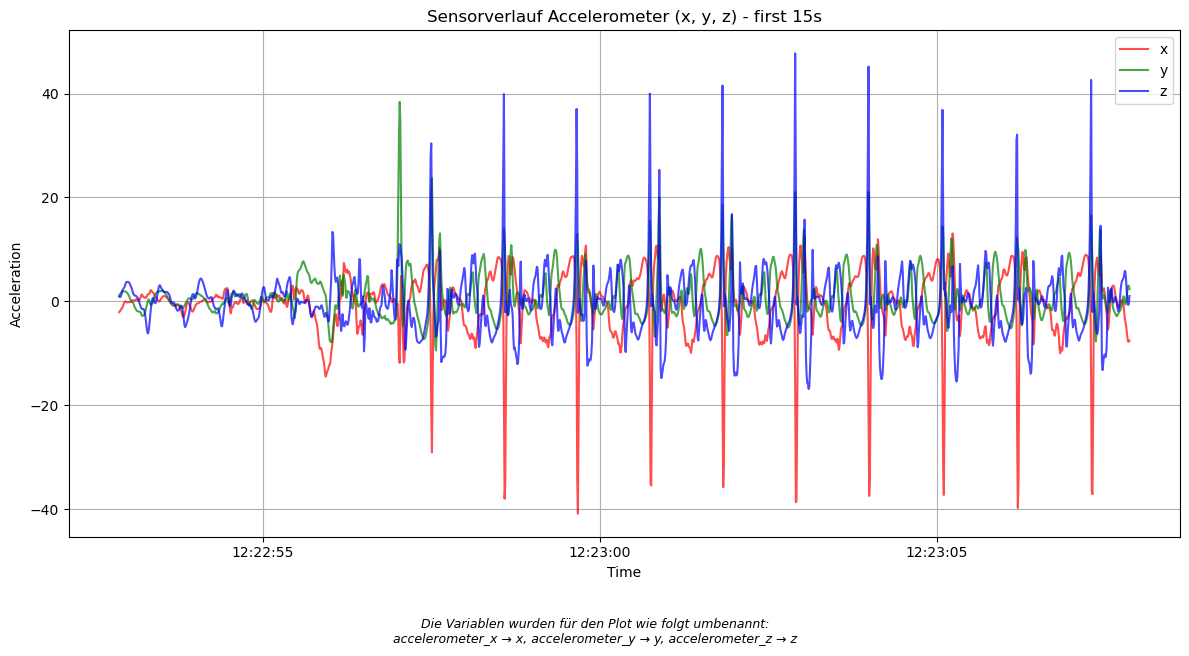

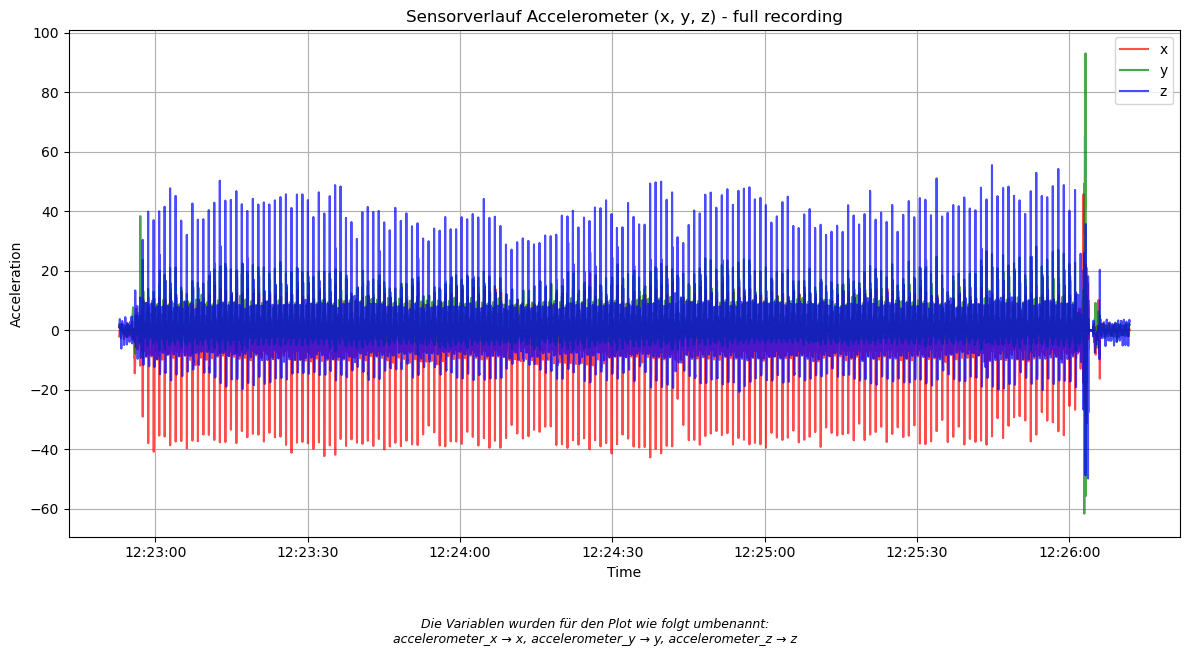

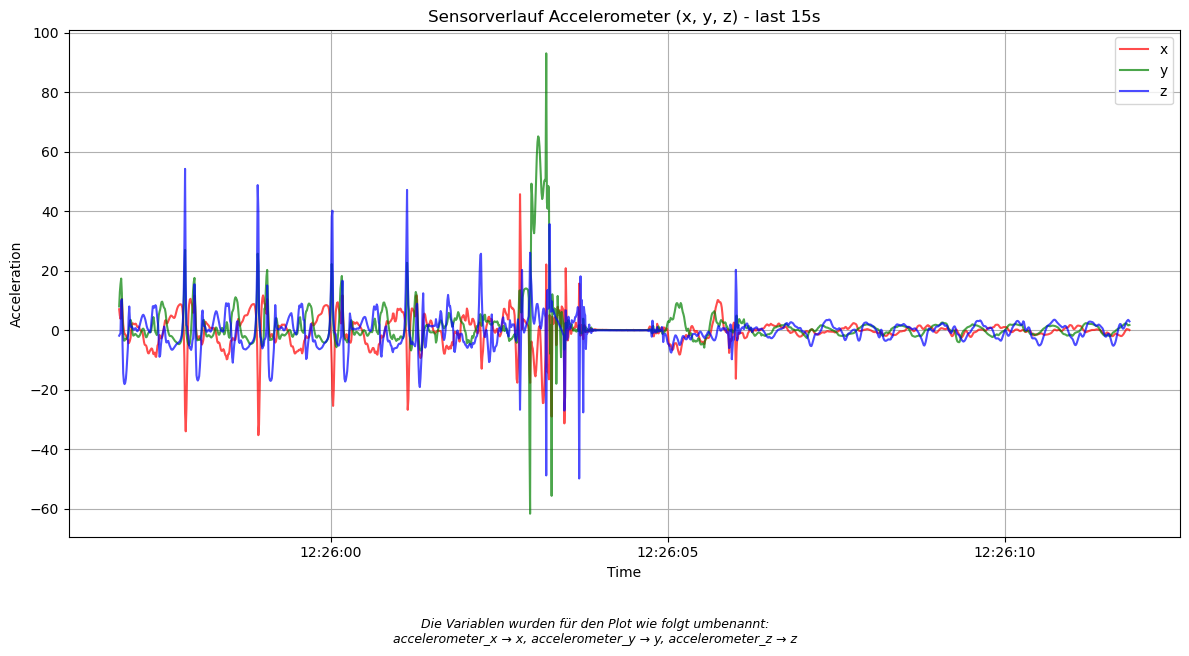

In [6]:
# Umbenennung der Accelerometer-Spalten
df_raw_full = df_raw_full.rename(columns={
    'accelerometer_x': 'x',
    'accelerometer_y': 'y',
    'accelerometer_z': 'z'
})

# Zeitstempel korrekt umwandeln
df_raw_full['time'] = pd.to_datetime(df_raw_full['time'], unit='ns')

# Extrahiere nur die relevanten x/y/z-Daten
df_acc_raw = df_raw_full[['time', 'x', 'y', 'z']].copy()
df_acc_raw = df_acc_raw.set_index('time').sort_index()

plot_data(df_acc_raw, title="Sensorverlauf Accelerometer (x, y, z) - first 15s", duration=15)
plot_data(df_acc_raw, title="Sensorverlauf Accelerometer (x, y, z) - full recording")
plot_data(df_acc_raw, title="Sensorverlauf Accelerometer (x, y, z) - last 15s", duration=-15)

 ---

 ## 2. Zeitbasiertes Trimmen & Resampling

Die Funktion preprocess_dataframe ist ein vielseitiges Werkzeug zur Vorbereitung von Zeitreihendaten für die Analyse. Sie nimmt ein pandas DataFrame mit Rohdaten, wie z. B. Sensordaten, und führt mehrere Vorverarbeitungsschritte durch, darunter Zeitkonvertierung, Zuschneiden, Resampling und Interpolation. Durch die Umwandlung von Zeitstempeln, das Filtern numerischer Spalten und das Resampling der Daten auf eine gewünschte Frequenz sorgt die Funktion dafür, dass die Daten sauber, konsistent und bereit für weitere Verarbeitung oder Modellierung sind. 

In [7]:
def preprocess_dataframe(
    df: pd.DataFrame,
    time_col: str = 'time',
    drop_initial: float = None,
    drop_final: float = None,
    sampling_rate: float = None,
    apply_trim: bool = True
) -> pd.DataFrame:
    """
    1. Konvertiere die Zeitspalte (Nanosekunden) in datetime-Objekte.
    2. Setze den Zeitstempel als Index und sortiere nach Zeit.
    3. Optional: Schneide die ersten 'drop_initial' und letzten 'drop_final' Sekunden ab.
    4. Resample auf die gewünschte 'sampling_rate' (Hz):
       - Mittelwert in jedem Intervall
       - lineare Interpolation fehlender Werte

    Rückgabe: DataFrame mit nur numerischen Spalten, indexiert nach Zeit in der neuen Sampling-Rate.
    """
    df = df.copy()
    if time_col not in df.columns:
        raise ValueError(f"Zeitspalte '{time_col}' nicht gefunden. Verfügbare Spalten: {df.columns.tolist()}")

    # 1. Zeitkonvertierung: Nanosekunden → pandas datetime
    df[time_col] = pd.to_datetime(df[time_col], unit='ns')

    # 2. Setze Zeitspalte als Index und sortiere
    df = df.set_index(time_col).sort_index()
    if df.empty:
        raise ValueError("DataFrame ist nach Setzen des Zeit-Index leer.")

    # 3. Optional: Trimme Anfang und Ende
    if apply_trim:
        start = df.index[0] + pd.Timedelta(seconds=drop_initial)
        end = df.index[-1] - pd.Timedelta(seconds=drop_final)
        df = df[(df.index >= start) & (df.index <= end)]
        if df.empty:
            raise ValueError("DataFrame ist nach Entfernen der Randzeiten leer.")

    # 4. Nur numerische Spalten auswählen (Sensorwerte)
    num_cols = df.select_dtypes(include='number').columns
    if len(num_cols) == 0:
        raise ValueError("Keine numerischen Spalten für das Resampling gefunden.")
    df_num = df[num_cols]

    # 5. Resampling
    rule = f"{int(1e6 / sampling_rate)}us"
    df_resampled = df_num.resample(rule).mean().interpolate()
    if df_resampled.empty:
        raise ValueError("DataFrame ist nach Resampling leer.")

    return df_resampled

Im nächsten Schritt extrahieren wir die Spalten time, x, y, z und wenden preprocess_dataframe() an, um:

* die Daten auf 50 Hz zu resamplen,

* jeweils 8 Sekunden am Anfang und Ende zu trimmen.

Diese Kennzahlen haben wir durch unsere Literaturrecherche ausgewählt und bereits unter Projekt Setup definiert.

Anschliessend plotten wir die verarbeiteten Daten (erste 15 s, gesamte Dauer, letzte 15 s) und vergleichen sie mit den Rohdaten. Der Vergleich zeigt klar die geglättete und gleichmäßig abgetastete Struktur der resampleten Daten.

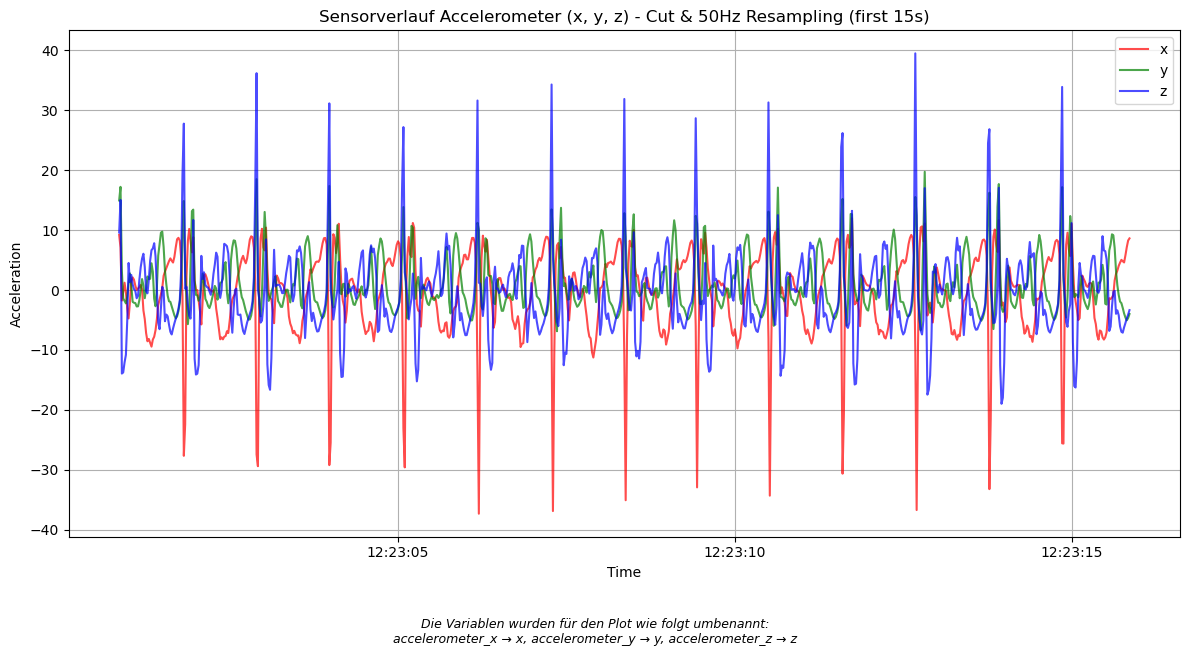

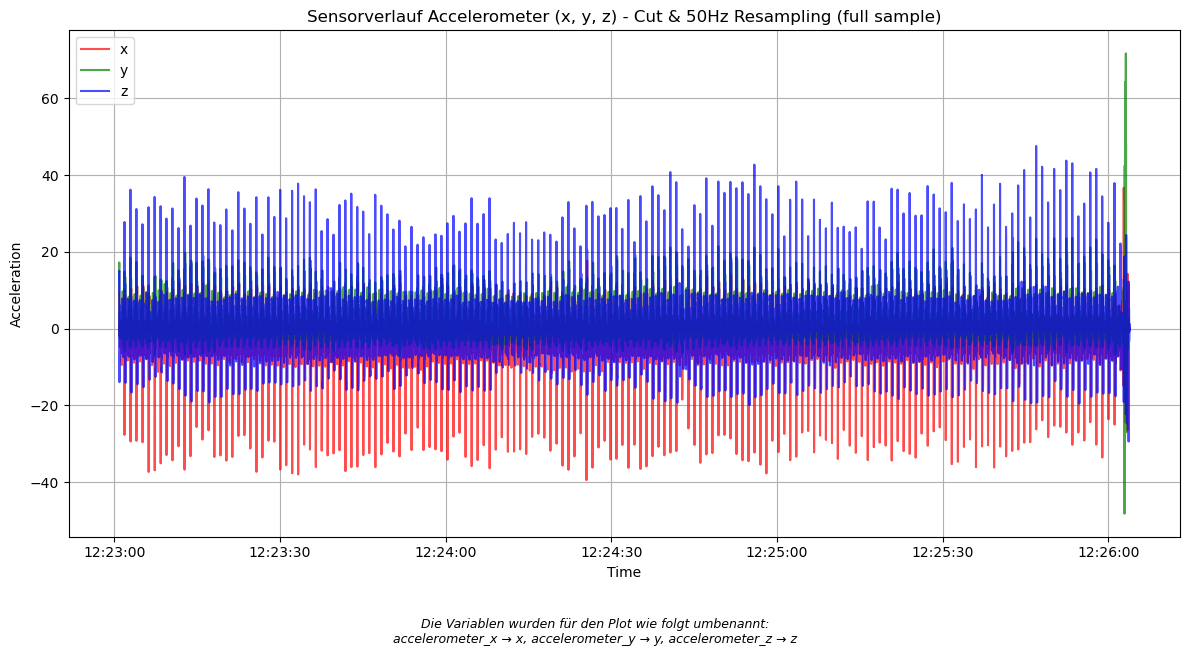

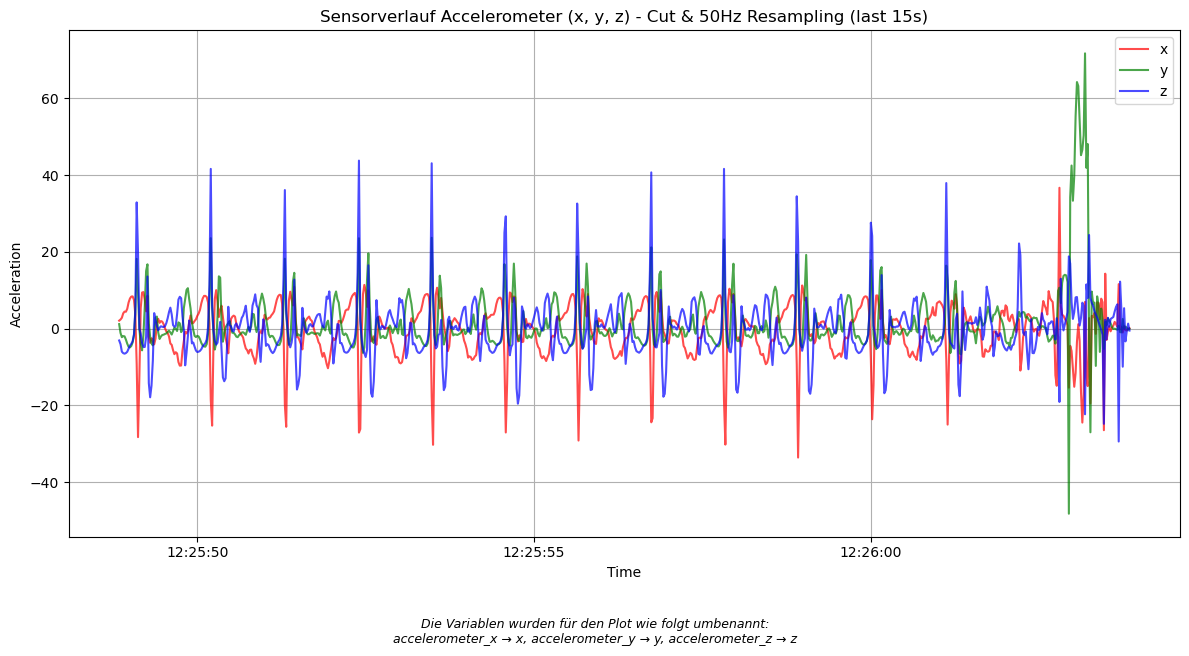

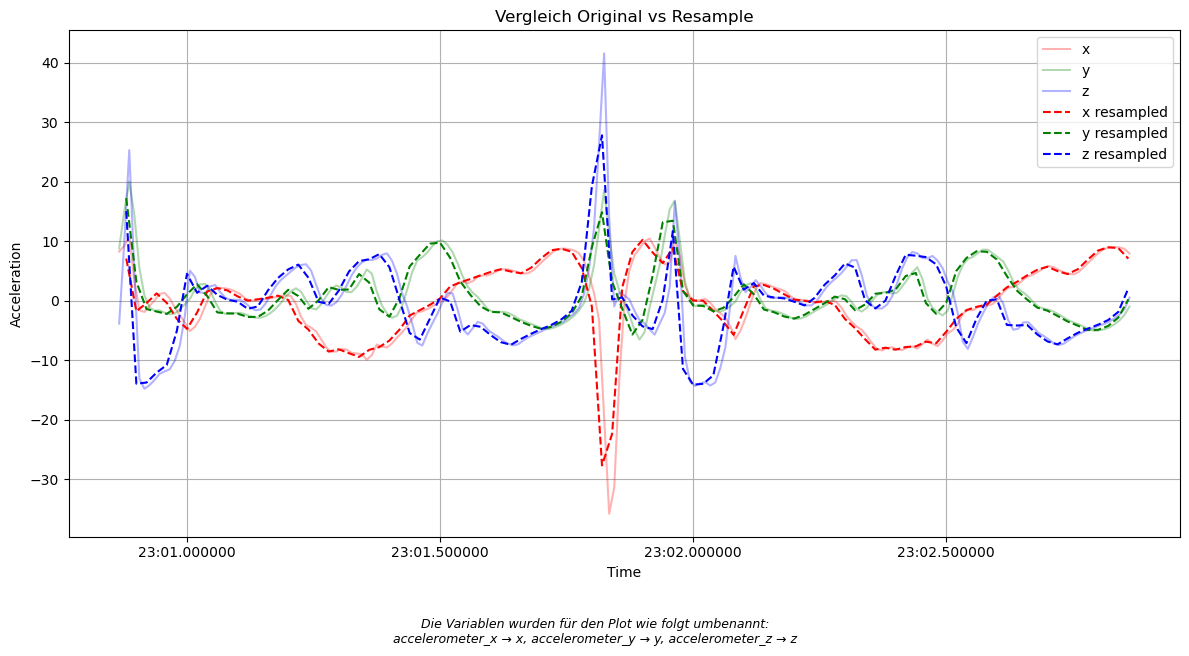

In [8]:
df_acc_input = df_raw_full[['time', 'x', 'y', 'z']].copy()
df_acc_processed = preprocess_dataframe(df_acc_input, drop_initial=TRIM_SEC, drop_final=TRIM_SEC, sampling_rate=SAMPLING_HZ)

# Visualisierung der verarbeiteten Daten
plot_data(df_acc_processed, title="Sensorverlauf Accelerometer (x, y, z) - Cut & 50Hz Resampling (first 15s)", duration=15)
plot_data(df_acc_processed, title="Sensorverlauf Accelerometer (x, y, z) - Cut & 50Hz Resampling (full sample)")
plot_data(df_acc_processed, title="Sensorverlauf Accelerometer (x, y, z) - Cut & 50Hz Resampling (last 15s)", duration=-15)

# Trim der Rohdaten auf denselben Zeitraum für Vergleich
start, end = df_acc_processed.index.min(), df_acc_processed.index.max()
df_acc_raw_trimmed = df_acc_raw[(df_acc_raw.index >= start) & (df_acc_raw.index <= end)]

# Vergleich Original vs. Resample
plot_data(df=df_acc_raw_trimmed, title="Vergleich Original vs Resample", duration=2, compare_to=df_acc_processed, alpha=0.3)

 ---

 ## 3. Segmentierung in überlappende Zeitfenster


Die Funktion segment_dataframe dient dazu, kontinuierliche Zeitreihendaten in gleich lange, überlappende Zeitfenster zu unterteilen. Dies ist ein zentraler Schritt bei der Vorbereitung von Sensordaten für Feature-Extraktion oder Deep-Learning-Modelle. Die Fensterlänge (z. B. 5 Sekunden) und die Überlappung (z. B. 1 Sekunde) lassen sich flexibel anpassen. Jedes zurückgegebene Segment ist ein DataFrame mit dem Zeitindex des ursprünglichen Signals und enthält genau den entsprechenden Abschnitt des Signals. So entsteht eine Serie überlappender, strukturierter Datenblöcke für die weitere Analyse.

In [9]:
def segment_dataframe(
    df: pd.DataFrame,
    segment_length: float = None,
    overlap: float = None
) -> list[pd.DataFrame]:
    """
    Teilt 'df' in überlappende Fenster auf:
    - segment_length: Länge eines Fensters in Sekunden (z.B. 5.0)
    - overlap: Überlappung zwischen Fenstern in Sekunden (z.B. 1.0)

    Rückgabe: Liste von DataFrames, jedes entspricht einem Segment (Index = Zeit).
    """
    seg_len = pd.Timedelta(seconds=segment_length)
    ov = pd.Timedelta(seconds=overlap)
    segments: list[pd.DataFrame] = []

    t0 = df.index.min()
    t_max = df.index.max()
    while t0 + seg_len <= t_max:
        t1 = t0 + seg_len
        seg = df[t0:t1]   # Schneide Index von t0 bis t1
        if not seg.empty:
            segments.append(seg)
        t0 = t1 - ov  # Nächster Startpunkt = Ende des alten Segments minus Overlap

    if not segments:
        raise ValueError("Keine Segmente erstellt. Überprüfe 'segment_length' und 'overlap'.")
    return segments

Nach dem Trimming und Resampling unterteilen wir die Zeitreihe in überlappende Segmente fester Länge – hier 5 Sekunden mit 2.5 Sekunde Überlappung für das beste Resultat gemäss Hammerla. Diese Segmentierung bildet die Grundlage für Feature-Extraktion oder sequenzbasierte Modellierung. Anschliessend werden exemplarisch die ersten drei Segmente visualisiert, um den Erfolg der Segmentierung zu überprüfen.

-------------------------------------
Anzahl der Segmente: 72
-------------------------------------


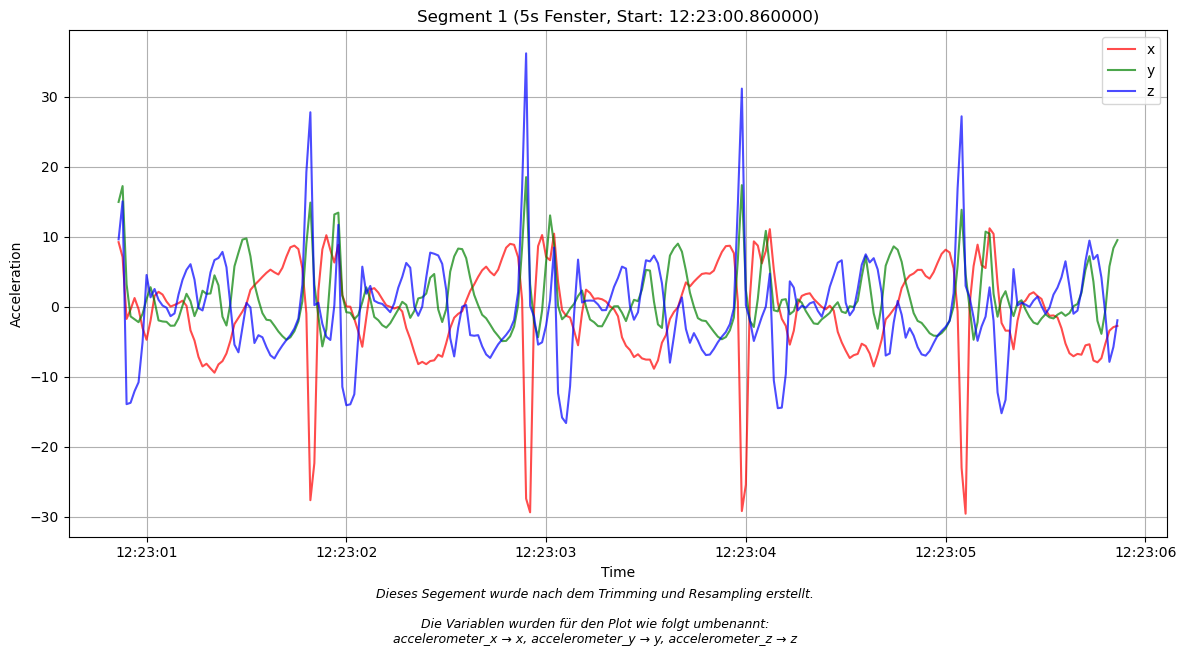

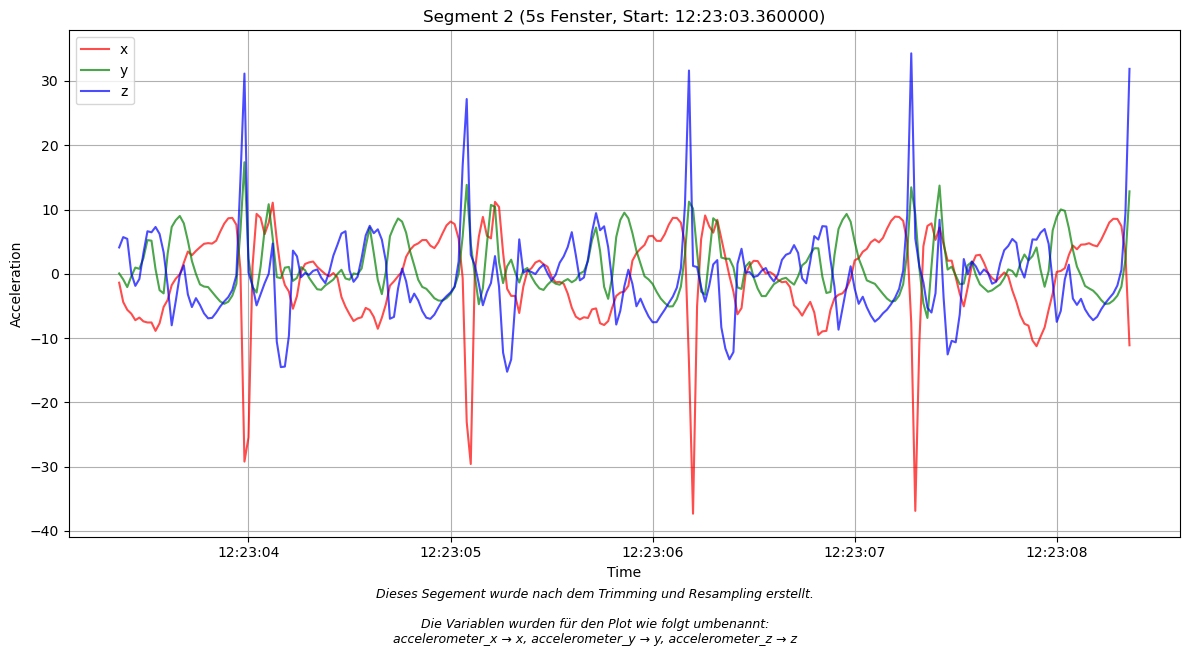

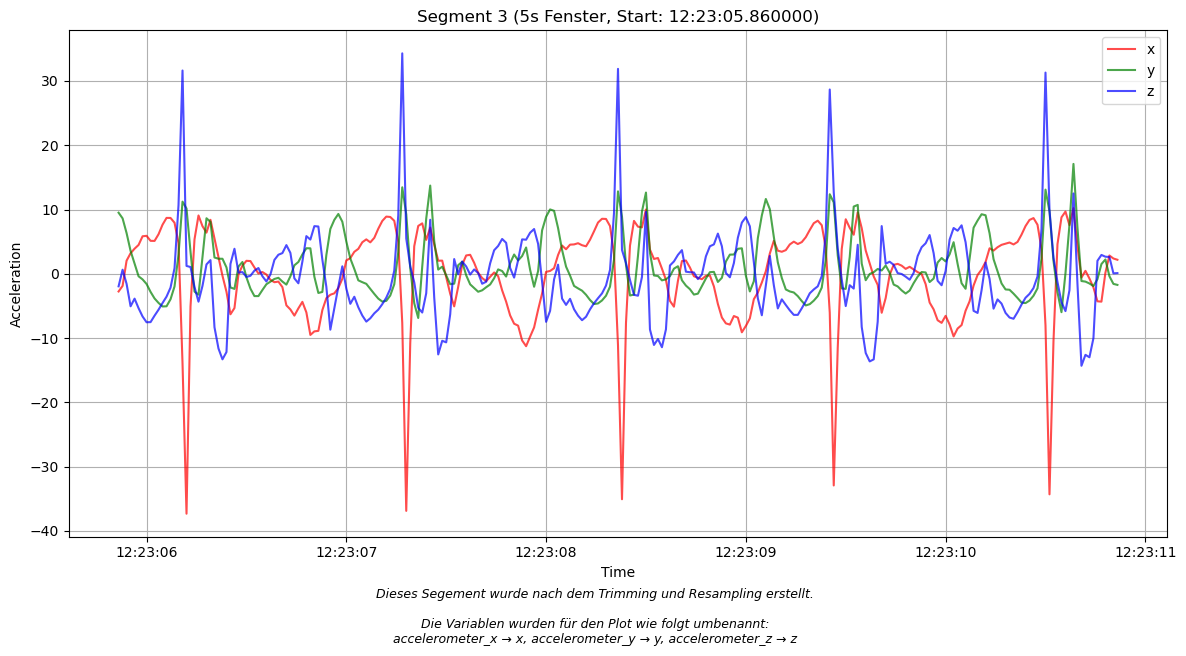

In [10]:
# Segmentierung der resampleten Daten durchführen
segments = segment_dataframe(df_acc_processed, segment_length=SEG_LEN, overlap=OVERLAP)

# Anzahl der erzeugten Segmente ausgeben
print("-------------------------------------")
print(f"Anzahl der Segmente: {len(segments)}")
print("-------------------------------------")

# Die ersten drei Segmente plotten
for i in range(min(3, len(segments))):
    seg_df = segments[i]
    title = f"Segment {i+1} (5s Fenster, Start: {seg_df.index.min().time()})"
    plot_data(seg_df, title=title, own_comment="Dieses Segement wurde nach dem Trimming und Resampling erstellt.")

 ---

 ## 4. Glättung jedes Segments

Die Funktion moving_average glättet die resampleten Zeitreihendaten segmentweise mithilfe eines gleitenden Durchschnitts. Dabei wird über ein definiertes Zeitfenster – z. B. 0.1 Sekunden bei einer Samplingrate von 50 Hz – der Mittelwert für jede Spalte berechnet. Diese Methode reduziert kurzfristige Schwankungen im Sensorsignal, ohne den grundlegenden Verlauf zu verändern.

Da die Glättung innerhalb der einzelnen Segmente erfolgt, wird verhindert, dass Informationen über Segmentgrenzen hinweg ungewollt einfließen (Data Leakage). Das macht sie ideal für klassische Machine-Learning-Modelle, bei denen eine stabile Signalbasis für die Merkmalsextraktion wichtig ist.

In [11]:
def moving_average(
    df: pd.DataFrame,
    window_sec: float = None,
    sampling_rate: float = None
) -> pd.DataFrame:
    """
    Wendet einen gleitenden Durchschnitt (Moving Average) auf alle Spalten von 'df' an:
    - window_sec: Fenstergröße in Sekunden (z.B. 0.1s)
    - sampling_rate: Sampling-Rate in Hz (z.B. 50)

    Rückgabe: Geglättetes DataFrame (gleiche Dimension wie Input).
    """
    w = int(window_sec * sampling_rate)
    if w < 1:
        w = 1
    df_smooth = df.rolling(window=w, center=True, min_periods=1).mean()
    return df_smooth

Im nächsten Schritt wenden wir diese Methode auf die ersten drei Segmente an und visualisieren das Ergebnis im Vergleich zur ungefilterten Version.

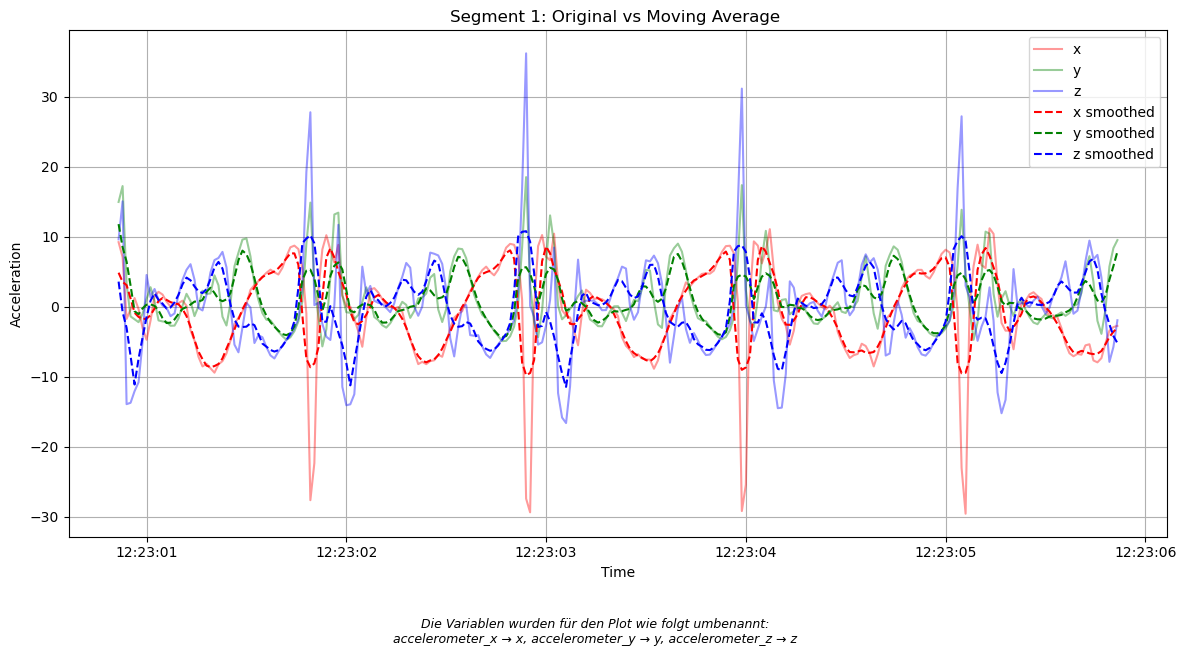

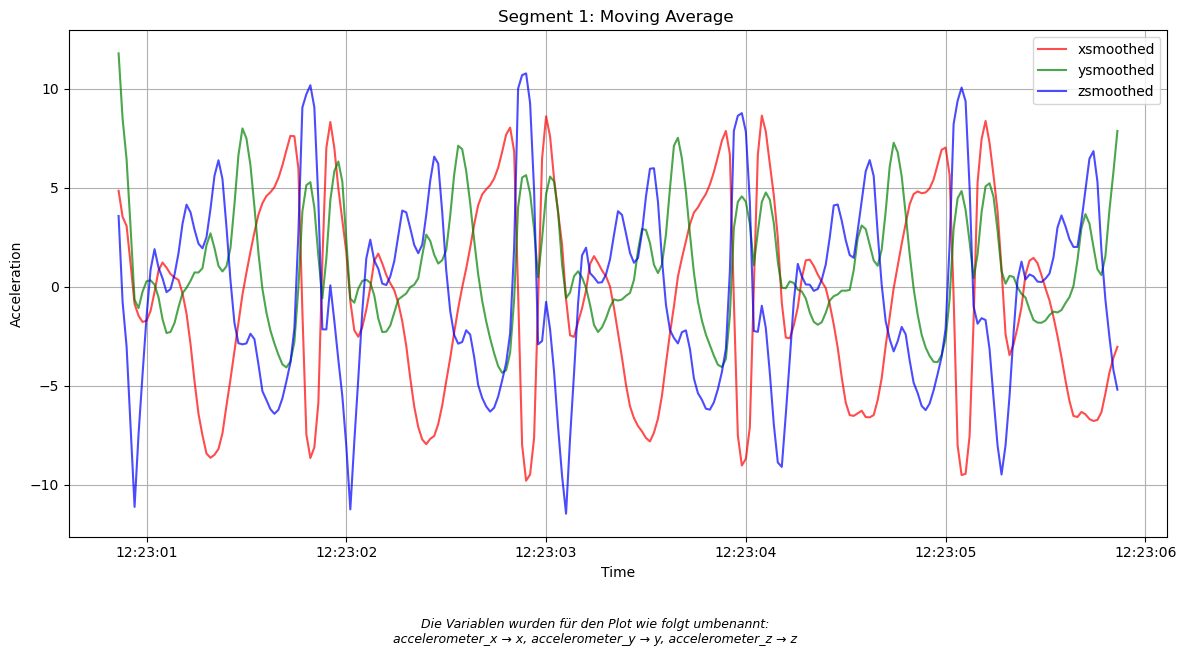

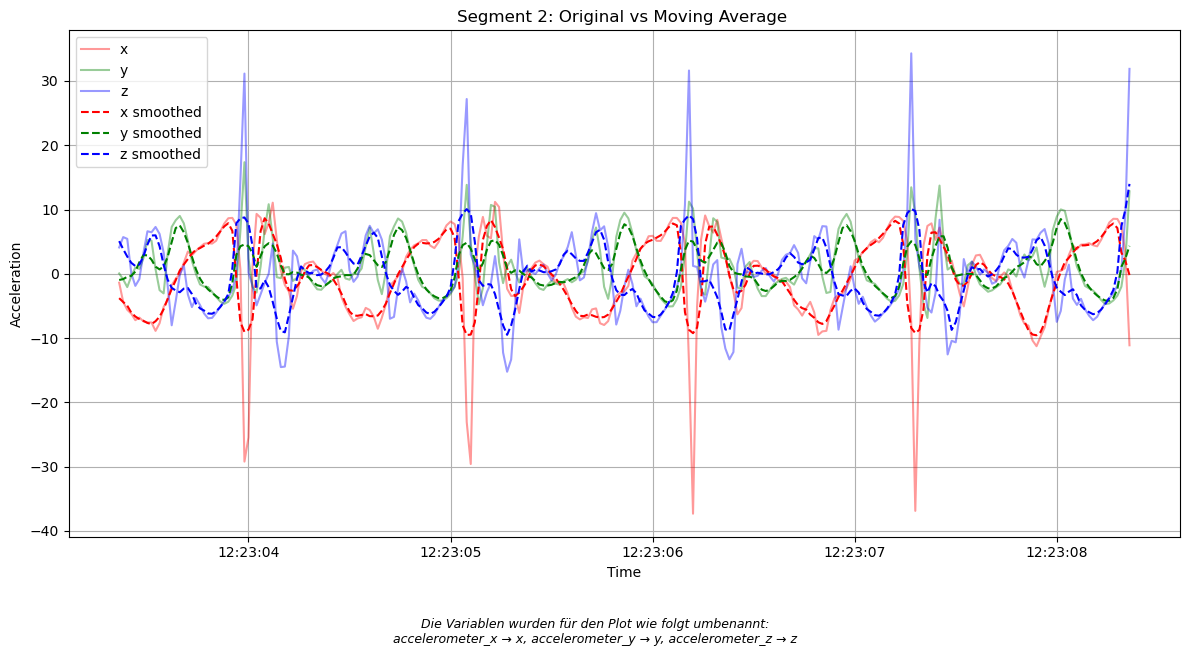

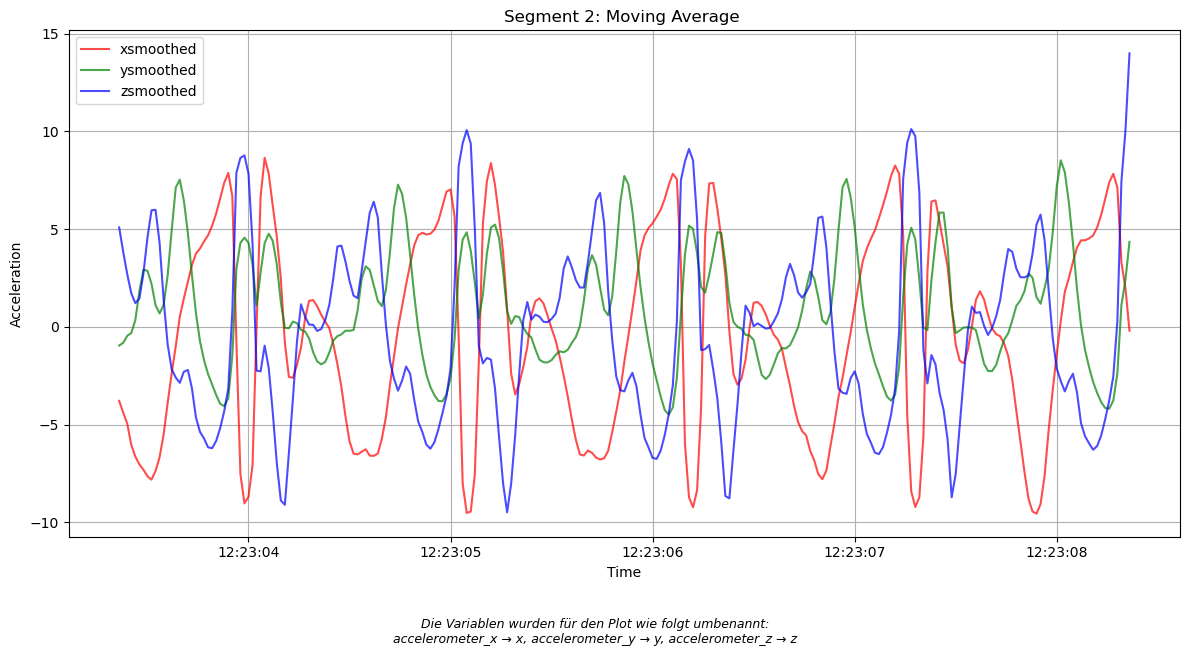

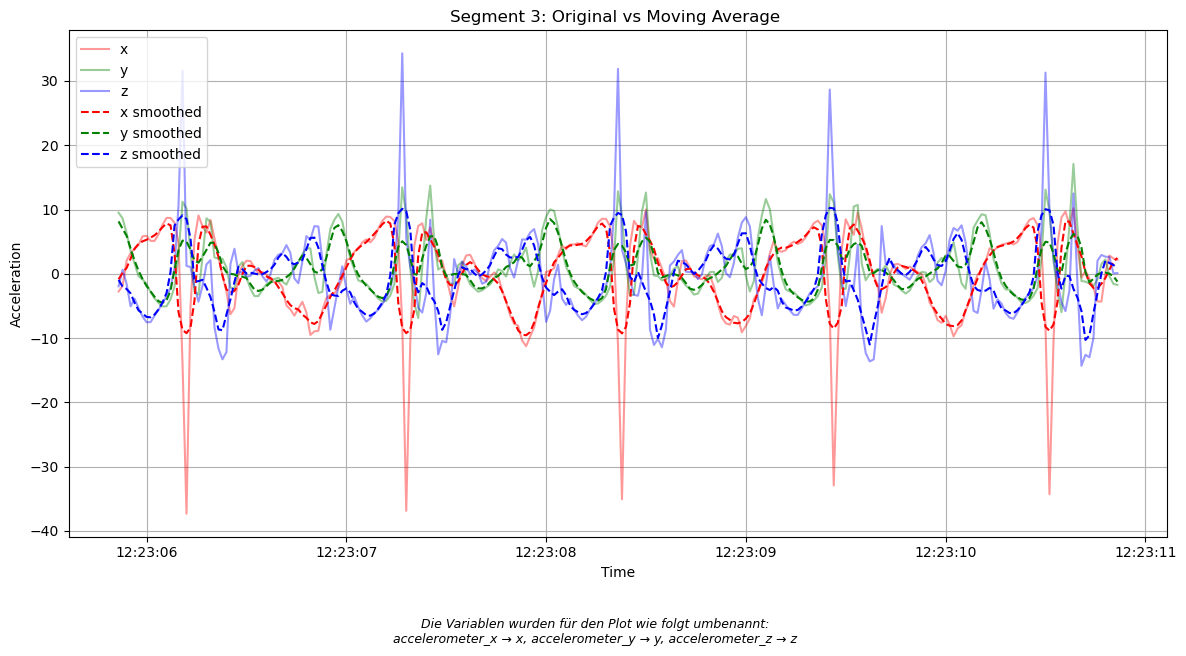

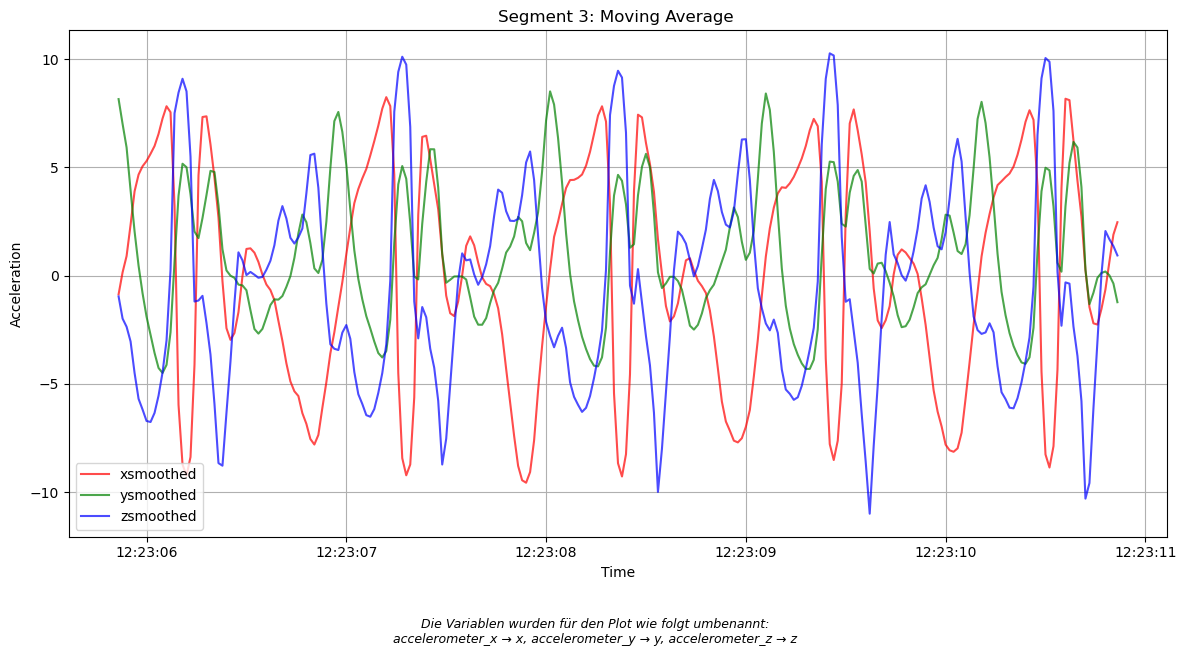

In [12]:
for i in range(min(3, len(segments))):
    seg = segments[i]

    seg_smooth = moving_average(seg, window_sec=SMOOTH_SEC, sampling_rate=SAMPLING_HZ)

    plot_data(
        df=seg,
        compare_to=seg_smooth,
        title=f"Segment {i+1}: Original vs Moving Average ",
        alpha=0.4,
        axes_name="",
        axes_name_compare=" smoothed"
    )
    plot_data(
        df=seg_smooth,
        title=f"Segment {i+1}: Moving Average ",
        alpha=0.7,
        axes_name="smoothed"
    )


 ---

 ## 5. Feature-Extraktion (für NDL)

Die Funktion extract_features berechnet für jedes Segment eine Reihe statistischer Kennwerte: Mittelwert, Standardabweichung, Minimum und Maximum – jeweils für jede Sensorkomponente (x, y, z). Diese Merkmale fassen die zeitliche Dynamik innerhalb eines Fensters kompakt zusammen und bilden eine typische Grundlage für Non Deepl Learning Modelle.

Jedes Segment wird zu einer Zeile im resultierenden Feature-DataFrame, wobei die Spalten die extrahierten Merkmale repräsentieren und der Index die Segment-ID darstellt.

In [13]:
def extract_features(segments: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Berechnet für jedes Segment die statistischen Kennwerte:
    - Mittelwert, Standardabweichung, Minimum, Maximum jeder Spalte.

    Rückgabe: DataFrame mit einer Zeile pro Segment und Index 'segment_id'.
    """
    rows = []
    for i, seg in enumerate(segments):
        feats: dict[str, float] = {}
        for col in seg.columns:
            feats[f"{col}_mean"] = seg[col].mean()
            feats[f"{col}_std"]  = seg[col].std()
            feats[f"{col}_min"]  = seg[col].min()
            feats[f"{col}_max"]  = seg[col].max()
        feats['segment_id'] = i
        rows.append(feats)

    if not rows:
        raise ValueError("Keine Segmente vorhanden. Feature-Extraktion nicht möglich.")
    return pd.DataFrame(rows).set_index('segment_id')

In [14]:
features_df = extract_features(segments)
features_df.head()

,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max
segment_id,,,,,,,,,,,,
0,-0.571236,7.013248,-29.595173,11.189922,1.135245,4.556929,-5.690416,18.506309,-0.238313,7.084551,-16.640926,36.192214
1,-0.374816,7.191392,-37.325786,11.189922,1.033659,4.362427,-6.874684,17.361292,-0.298044,6.859969,-15.237707,34.301258
2,0.020069,7.409637,-37.325786,10.214587,1.062338,4.572914,-6.874684,17.099499,-0.457208,6.962341,-14.310388,34.301258
3,-0.552780,7.359243,-36.713822,11.973195,1.079262,4.753964,-6.691670,19.733188,0.046681,7.496711,-17.451313,39.502492
4,-0.375314,7.095878,-36.713822,11.973195,0.969579,4.900367,-6.691670,19.733188,-0.315435,7.517098,-18.981602,39.502492


 ---

 ## 6. Label-Zuordnung

Die Funktion get_label_per_segment weist jedem Segment ein Label zu, basierend auf den im ursprünglichen Rohdaten-DataFrame enthaltenen Aktivitätsannotationen. Für jedes Segment wird das Zeitintervall bestimmt und der häufigste Wert (Modalwert) der Aktivität innerhalb dieses Zeitfensters ermittelt. Diese Vorgehensweise eignet sich besonders bei leicht verrauschten oder uneinheitlichen Annotationen.

In [15]:
def get_label_per_segment(
    raw_df: pd.DataFrame,
    segments: list[pd.DataFrame],
    time_col: str = 'time',
    label_col: str = 'activity'
) -> list:
    """
    Ordnet jedem Segment das Label zu, das im Original-DataFrame (raw_df) am häufigsten vorkommt:
    - raw_df enthält die Rohdaten mit Zeitstempel und Label-Spalte.
    - segments sind bereits gefilterte/glättete DataFrames mit Index=Zeit.

    Rückgabe: Liste von Labels (Modalwert) pro Segment. Fehlt ein Label, wird None gesetzt.
    """
    if label_col not in raw_df.columns:
        raise ValueError(f"Spalte '{label_col}' nicht in raw_df vorhanden.")

    # Indexiere raw_df nach Zeit
    label_series = raw_df.set_index(pd.to_datetime(raw_df[time_col], unit='ns'))[label_col]
    labels = []

    for seg in segments:
        start_ts = seg.index.min()
        end_ts   = seg.index.max()
        seg_labels = label_series[start_ts:end_ts]
        if not seg_labels.empty:
            labels.append(seg_labels.mode().iloc[0])
        else:
            labels.append(None)
    return labels

Diese Methode ist notwendig für klassisches Supervised Learning – denn jedes Segment benötigt ein eindeutiges Ziel-Label (z. B. "sitting", “walking”, “jogging”). Sie funktioniert auch dann robust, wenn mehrere Labels innerhalb eines Fensters vorkommen, indem einfach das am häufigsten auftretende verwendet wird.

Fehlt ein Label im betrachteten Zeitfenster, wird None zugewiesen.

In [16]:
labels_per_segment = get_label_per_segment(
    raw_df=df_raw_full,
    segments=segments,
)

print(f"Anzahl Labels: {len(labels_per_segment)}")
print("Erste 10 Labels:", labels_per_segment[:10])
print(f"Kontrolle Labels: {pd.Series(labels_per_segment).value_counts()}")

if len(labels_per_segment) != len([label for label in labels_per_segment if label is not None]):
    raise ValueError("Anzahl der Labels stimmt nicht mit der Anzahl der Segmente überein.")
else:
    print("✅ Alle Segmente haben ein eindeutiges zugeordnetes Label.")

Anzahl Labels: 72
Erste 10 Labels: ['walking', 'walking', 'walking', 'walking', 'walking', 'walking', 'walking', 'walking', 'walking', 'walking']
Kontrolle Labels: walking    72
Name: count, dtype: int64
✅ Alle Segmente haben ein eindeutiges zugeordnetes Label.


 ---

 ## 7. Sequenzbildung (für DL)
 
Die Funktion get_files_list dient dazu, Eingabedateien für die weitere Verarbeitung zu sammeln. Sie akzeptiert entweder:

-> einen einzelnen Dateipfad (z. B. eine .parquet-Datei), oder

-> ein Verzeichnis, aus dem alle Dateien passend zum angegebenen Muster (z. B. *.parquet) extrahiert werden.

Sie prüft die Eingabe auf Gültigkeit und gibt eine Liste von Path-Objekten zurück, die anschliessend iterativ verarbeitet werden können.

In [17]:
def get_files_list(raw_dir: Path, pattern: str = "*.parquet") -> list[Path]:
    """
    Gibt eine Liste von Parquet-Dateien zurück:
    - Wenn raw_dir eine Datei ist, wird diese Datei in einer Liste zurückgegeben.
    - Wenn raw_dir ein Verzeichnis ist, werden alle Dateien, die zu 'pattern' passen (z.B. '*.parquet'), zurückgegeben.

    Rückgabe: Liste von Path-Objekten
    """
    if raw_dir.is_file():
        return [raw_dir]
    elif raw_dir.is_dir():
        files = list(raw_dir.glob(pattern))
        if not files:
            raise ValueError(f"Keine Dateien mit Muster '{pattern}' in '{raw_dir}' gefunden.")
        return files
    else:
        raise ValueError(f"'{raw_dir}' ist weder eine Datei noch ein Verzeichnis.")

---

 ## 8 Kreative Alternativen



 * Wavelet-Denoising (`pywt`)

 *

 * Butterworth-Bandpass 0.3 – 15 Hz (`scipy.signal.butter / filtfilt`)



 👉 Hier können alternative Filter implementiert und mit den QC-Plots verglichen werden.

---

 ## 10 Lessons Learned



 * ✔ Moving-Average glättet Noise ohne Phase-Shift

 * ✔ CFG-Block → Hyperparameter-Sweeps sehr einfach

 * ❌ Fixes Trimming ± 8 s verwirft kurze Sessions → adaptive Lösung nötig

 * ❌ Handling fehlender Gyro-Spalten noch offen

---

 ## 11 Links zu Modell-Notebooks



 * **Classical ML** – `Sensory Activity Challenge – non_deep_learning_models.ipynb`

 * **Deep Learning** – `Sensory Activity Challenge – deep_learning_models.ipynb`


